In [1]:
import pandas as pd
import numpy as np
import rdkit
import rdkit.Chem.AllChem
from tqdm import tqdm
from copy import deepcopy
import random
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
from IPython.core.display import Image, display
def show_atom_number_2D(mol, label = 'atomNote'):
    mol_2D = deepcopy(mol)
    rdkit.Chem.rdDepictor.Compute2DCoords(mol_2D)
    for atom in mol_2D.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol_2D

def display_mol_with_index(mol):
    return display(rdkit.Chem.Draw.MolToImage(show_atom_number_2D(mol), size=(400, 400)))

def display_mol(mol):
    mol_2D = deepcopy(mol)
    rdkit.Chem.rdDepictor.Compute2DCoords(mol_2D)
    return display(rdkit.Chem.Draw.MolToImage(mol_2D, size=(400, 400)))

/state/partition1/slurm_tmp/27683005.0.0/ipykernel_1049127/3981475789.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [3]:
def get_COOH_idx(mol):
    
    substructure = rdkit.Chem.MolFromSmarts('[CX3](=O)[OX2H1]')
    indexsall = mol.GetSubstructMatches(substructure)
    o_append=[]
    for i, num in enumerate(range(mol.GetNumAtoms())):
        if i in indexsall[0]:
            if mol.GetAtomWithIdx(i).GetSymbol() == 'C':
                C1 = i
            if mol.GetAtomWithIdx(i).GetSymbol() == 'O':
                o_append.append(i)
    for o in o_append:
        if mol.GetBondBetweenAtoms(o,C1).GetBondType() == rdkit.Chem.rdchem.BondType.SINGLE:
            O3 = o
        if mol.GetBondBetweenAtoms(o,C1).GetBondType() == rdkit.Chem.rdchem.BondType.DOUBLE:
            O2 = o
    for nei in mol.GetAtomWithIdx(C1).GetNeighbors():
        if nei.GetSymbol() =='C':
            C4 = nei.GetIdx()
    for nei in mol.GetAtomWithIdx(O3).GetNeighbors():
        if nei.GetSymbol() =='H':
            H5 = nei.GetIdx()
            
    return C1, O2, O3, C4, H5

from morfeus import BuriedVolume, Sterimol
def prop_calc_acid(m) :
    
    #get index of acid
    C1, O2, O3, C4, H5 = get_COOH_idx(m)
    
    #need xyz coords and elements
    coords = m.GetConformers()[0].GetPositions()
    elements = np.array([atom.GetSymbol() for atom in m.GetAtoms()])
    #Sterimol
    L_C1_C4 = Sterimol(elements, coords, C1+1, C4+1).L_value
    B5_C1_C4 = Sterimol(elements, coords, C1+1, C4+1).B_5_value
    #B1_C1_C4 = Sterimol(elements, coords, C1+1, C4+1).B_1_value
    
    return L_C1_C4, B5_C1_C4 

In [23]:
### PARAMETERS ###

prop = 'Sterimol_B5'
agg = 'min'


# collecting all inference metrics

results_dict_seeds = {}

for SEED in [0,1,2]:
    
    directory = f'jobs_acid_benchmark_seed{SEED}/'
    results_dict = {}
    
    dirs = [
        directory + f'jobs_active/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # active
        directory + f'jobs_perturbed/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_xtb_1000_seed{SEED}', # active xTB
        directory + f'jobs_perturbed/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_rdkit_1000_seed{SEED}', # active MMFF94
        
        directory + f'jobs/bond_{prop}_{agg}_random_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # random DFT
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # random xtb
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # random rdkit
        
        directory + f'jobs_augmented/bond_{prop}_{agg}_random_DFT_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # augmented with 10 dft
        directory + f'jobs_augmented/bond_{prop}_{agg}_random_xtb_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # augmented with 10 xtb
        directory + f'jobs_augmented/bond_{prop}_{agg}_random_rdkit_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # augmented with 10 rdkit
        
        directory + f'jobs_ensemble/bond_{prop}_{agg}_random_xtb_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_0_rdkit_0', # ensemble of 10 xtb
        directory + f'jobs_ensemble/bond_{prop}_{agg}_random_rdkit_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_0_rdkit_0', # ensemble of 10 MMFF94

    ]
    
    for d in tqdm(dirs):
        
        if 'augmented' not in d:
            results = np.load(f'{d}/test_predictions.npy')
            targets = results[0]
            pred_targets = results[1]
            MAE = np.mean(np.abs(targets - pred_targets))
            R2 = np.corrcoef(targets, pred_targets)[0][1] ** 2
            results_dict[d] = (MAE, R2)
            
        else:
            results = np.load(f'{d}/test_predictions.npy')
            targets = results[0]
            pred_targets = results[1]
            
            # averaging predictions over test-time conformers
            df = pd.read_pickle(f'{d}/test_df.pkl')
            df['y_pred'] = pred_targets
            df = df.drop_duplicates(subset = ['Name_int', 'mols'])[['Name_int', 'y', 'y_pred']].groupby('Name_int').apply(lambda x: x.mean())
            targets = np.array(df['y'])
            pred_targets = np.array(df['y_pred'])
            
            MAE = np.mean(np.abs(targets - pred_targets))
            R2 = np.corrcoef(targets, pred_targets)[0][1] ** 2
            results_dict[d] = (MAE, R2)
            
        results_dict_seeds[SEED] = results_dict

100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


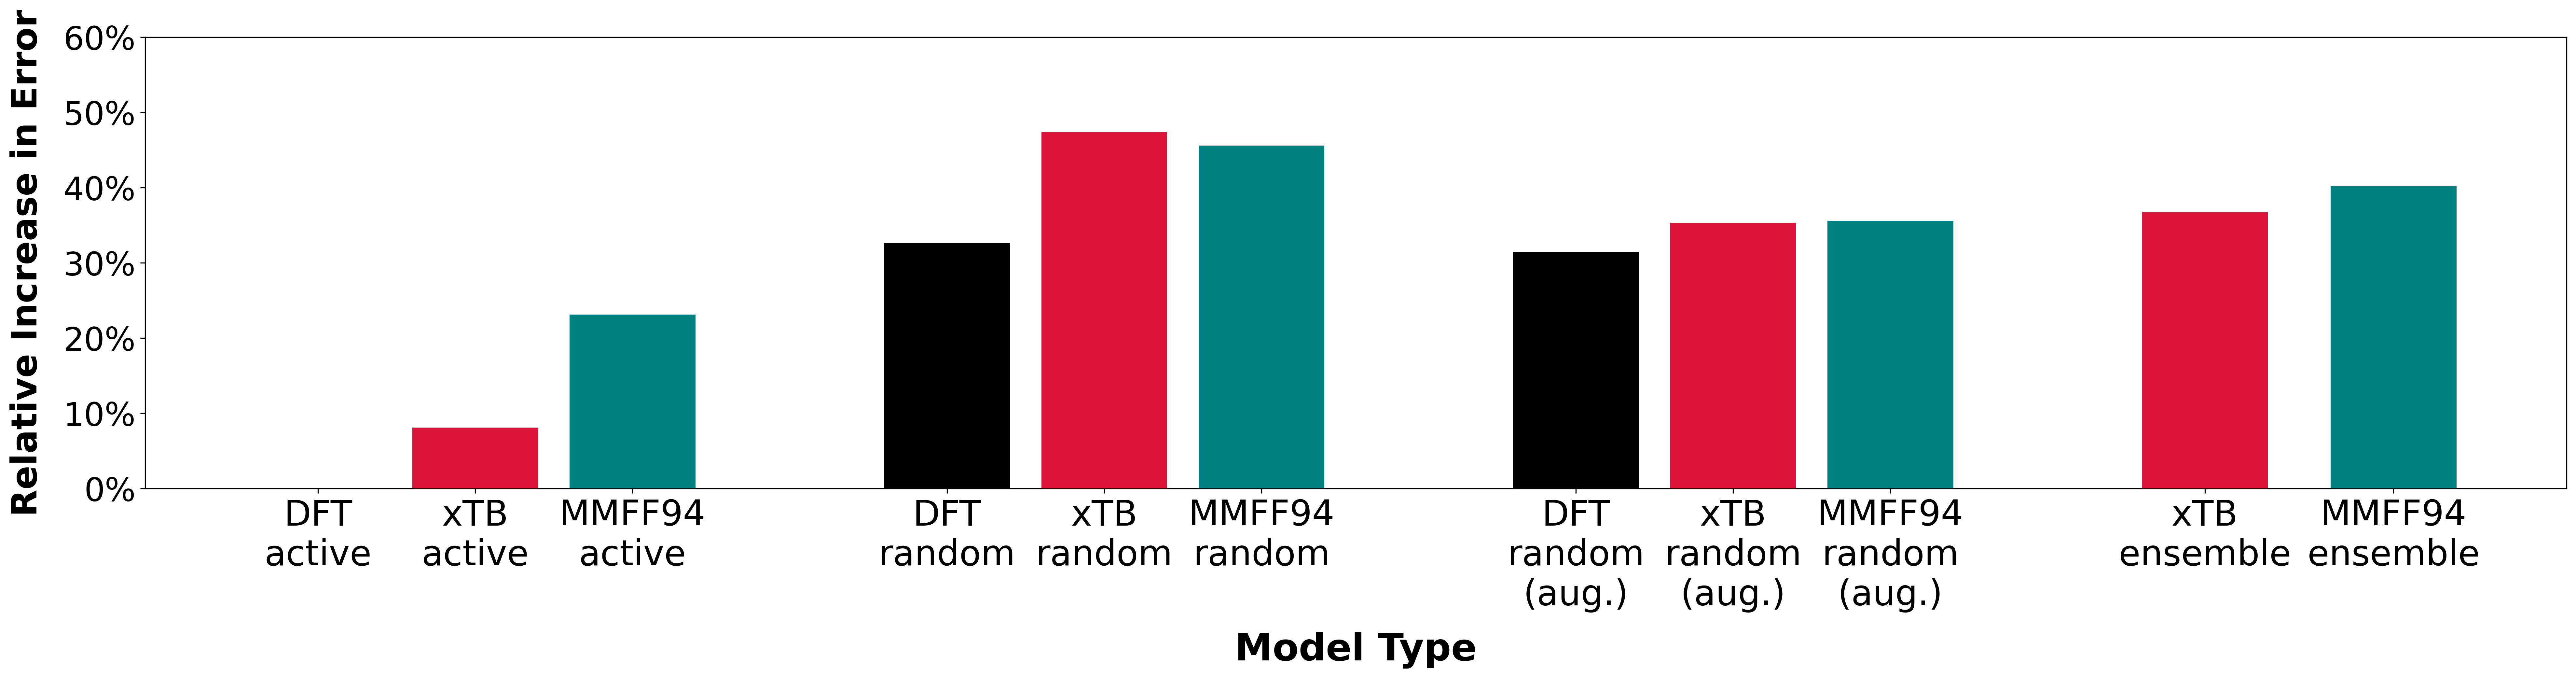

In [24]:
mae_seeds = []

for SEED in [0,1,2]:
    results_dict = results_dict_seeds[SEED]
    directory = f'jobs_acid_benchmark_seed{SEED}/'

    dirs = [
        directory + f'jobs_active/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # active
        directory + f'jobs_perturbed/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_xtb_1000_seed{SEED}', # active xTB
        directory + f'jobs_perturbed/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_rdkit_1000_seed{SEED}', # active MMFF94
        
        directory + f'jobs/bond_{prop}_{agg}_random_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # random DFT
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # random xtb
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # random rdkit
        
        directory + f'jobs_augmented/bond_{prop}_{agg}_random_DFT_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # augmented with 10 dft
        directory + f'jobs_augmented/bond_{prop}_{agg}_random_xtb_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # augmented with 10 xtb
        directory + f'jobs_augmented/bond_{prop}_{agg}_random_rdkit_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # augmented with 10 rdkit
        
        directory + f'jobs_ensemble/bond_{prop}_{agg}_random_xtb_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_0_rdkit_0', # ensemble of 10 xtb
        directory + f'jobs_ensemble/bond_{prop}_{agg}_random_rdkit_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_0_rdkit_0', # ensemble of 10 MMFF94

    ]
    
    maes = []
    for k in dirs:
        assert k in results_dict
        mae = results_dict[k][0].round(3)
        maes.append(mae)
    mae_seeds.append(maes)
mae_seeds = np.array(mae_seeds)


rel_mae_seeds = (mae_seeds -  mae_seeds[:, 0:1]) / mae_seeds[:, 0:1]
mean_per_model = (mae_seeds).mean(axis = 0)
std_per_model = (mae_seeds).std(axis = 0)
rel_mean_per_model = (rel_mae_seeds).mean(axis = 0)
rel_std_per_model = (rel_mae_seeds).std(axis = 0)


plt.figure(figsize = (32,6), dpi = 300)
plt.bar([0,1,2, 4,5,6, 8,9,10, 12,13.2], rel_mean_per_model * 100, color = ['black', 'crimson', 'teal'] * 3 + ['crimson', 'teal']) #, yerr = rel_std_per_model * 100)
plt.xticks([0,1,2, 4,5,6, 8,9,10, 12,13.2], 
           ['DFT\nactive',
            'xTB\nactive',
            'MMFF94\nactive',
            
            'DFT\nrandom',
            'xTB\nrandom',
            'MMFF94\nrandom',
            
            'DFT\nrandom\n(aug.)',
            'xTB\nrandom\n(aug.)',
            'MMFF94\nrandom\n(aug.)',
            
            'xTB\nensemble',
            'MMFF94\nensemble',
            
           ], fontsize = 26)
plt.yticks(
    [0, 10, 20, 30, 40, 50, 60, 70, 80][0:-2], 
    ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%'][0:-2], 
    fontsize = 24)
plt.xlabel('Model Type', fontsize=28, labelpad=14, fontweight='bold')
plt.ylabel('Relative Increase in Error', fontsize=26, labelpad=14, fontweight='bold')
plt.show()


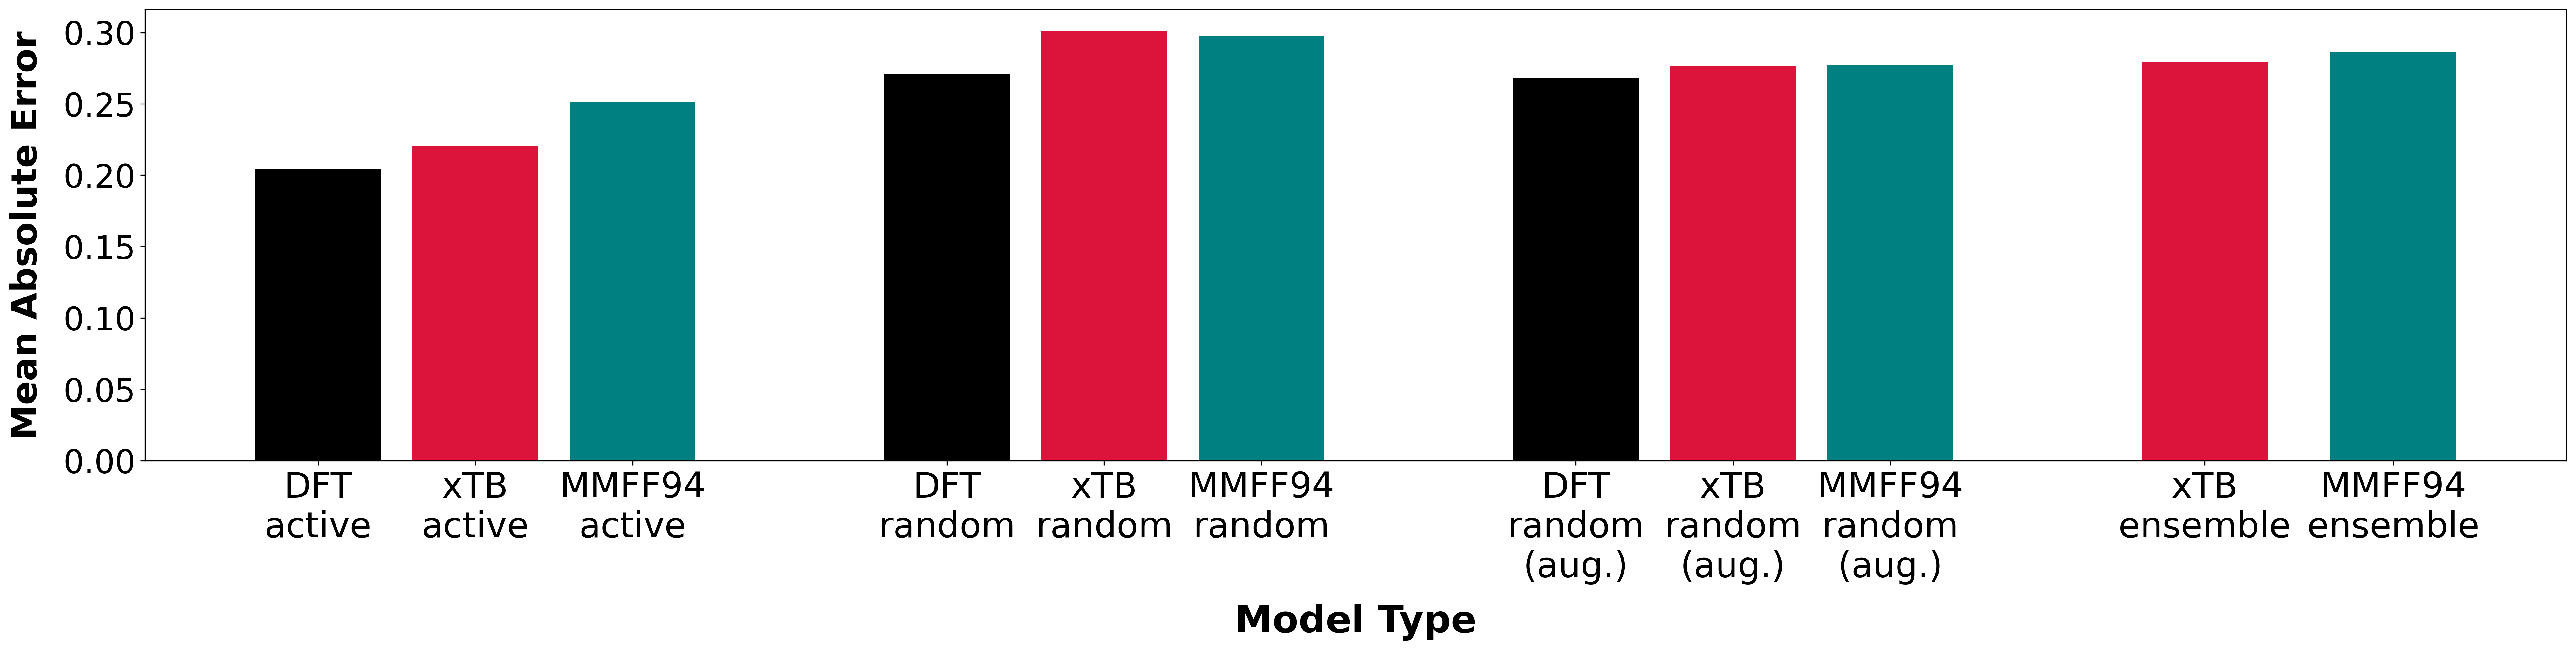

In [25]:
mae_seeds = []

for SEED in [0,1,2]:
    results_dict = results_dict_seeds[SEED]
    directory = f'jobs_acid_benchmark_seed{SEED}/'

    dirs = [
        directory + f'jobs_active/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # active
        directory + f'jobs_perturbed/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_xtb_1000_seed{SEED}', # active xTB
        directory + f'jobs_perturbed/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_rdkit_1000_seed{SEED}', # active MMFF94
        
        directory + f'jobs/bond_{prop}_{agg}_random_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # random DFT
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # random xtb
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # random rdkit
        
        directory + f'jobs_augmented/bond_{prop}_{agg}_random_DFT_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # augmented with 10 dft
        directory + f'jobs_augmented/bond_{prop}_{agg}_random_xtb_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # augmented with 10 xtb
        directory + f'jobs_augmented/bond_{prop}_{agg}_random_rdkit_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # augmented with 10 rdkit
        
        directory + f'jobs_ensemble/bond_{prop}_{agg}_random_xtb_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_0_rdkit_0', # ensemble of 10 xtb
        directory + f'jobs_ensemble/bond_{prop}_{agg}_random_rdkit_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_0_rdkit_0', # ensemble of 10 MMFF94

    ]
    
    maes = []
    for k in dirs:
        assert k in results_dict
        mae = results_dict[k][0].round(3)
        maes.append(mae)
    mae_seeds.append(maes)
mae_seeds = np.array(mae_seeds)


rel_mae_seeds = (mae_seeds -  mae_seeds[:, 0:1]) / mae_seeds[:, 0:1]
mean_per_model = (mae_seeds).mean(axis = 0)
std_per_model = (mae_seeds).std(axis = 0)
rel_mean_per_model = (rel_mae_seeds).mean(axis = 0)
rel_std_per_model = (rel_mae_seeds).std(axis = 0)


plt.figure(figsize = (32,6), dpi = 300)
plt.bar([0,1,2, 4,5,6, 8,9,10, 12,13.2], mean_per_model, color = ['black', 'crimson', 'teal'] * 3 + ['crimson', 'teal']) #, yerr = rel_std_per_model * 100)
plt.xticks([0,1,2, 4,5,6, 8,9,10, 12,13.2], 
           ['DFT\nactive',
            'xTB\nactive',
            'MMFF94\nactive',
            
            'DFT\nrandom',
            'xTB\nrandom',
            'MMFF94\nrandom',
            
            'DFT\nrandom\n(aug.)',
            'xTB\nrandom\n(aug.)',
            'MMFF94\nrandom\n(aug.)',
            
            'xTB\nensemble',
            'MMFF94\nensemble',
            
           ], fontsize = 26)
plt.yticks(fontsize = 24)
#plt.yticks(
#    [0, 10, 20, 30, 40, 50, 60, 70, 80][0:-2], 
#    ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%'][0:-2], 
#    fontsize = 24)
plt.xlabel('Model Type', fontsize=28, labelpad=14, fontweight='bold')
plt.ylabel('Mean Absolute Error', fontsize=26, labelpad=14, fontweight='bold')
plt.show()


In [22]:
print(prop, agg)
mean_per_model.round(3)

Sterimol_B5 max


array([0.155, 0.172, 0.185, 0.209, 0.229, 0.226, 0.208, 0.207, 0.207,
       0.223, 0.22 ])

In [26]:
print(prop, agg)
mean_per_model.round(3)

Sterimol_B5 min


array([0.204, 0.221, 0.252, 0.271, 0.301, 0.297, 0.268, 0.276, 0.277,
       0.279, 0.286])

In [18]:
print(prop, agg)
mean_per_model.round(3)

Sterimol_L max


array([0.185, 0.219, 0.247, 0.276, 0.316, 0.322, 0.278, 0.293, 0.295,
       0.303, 0.31 ])

In [14]:
print(prop, agg)
mean_per_model.round(3)

Sterimol_L min


array([0.134, 0.156, 0.18 , 0.204, 0.214, 0.216, 0.206, 0.203, 0.202,
       0.208, 0.217])

In [175]:
SEED = 1
results_dict = results_dict_seeds[SEED]
directory = f'jobs_acid_benchmark_seed{SEED}/'
dirs = [
       directory + f'jobs_active/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # active
       directory + f'jobs_perturbed/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_xtb_1000_seed{SEED}', # active xTB 
       directory + f'jobs_perturbed/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_rdkit_1000_seed{SEED}', # active MMFF94 ; this is suspicious just for seed=1 --> identical to xTB version 
       
       directory + f'jobs/bond_{prop}_{agg}_random_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # random DFT
       directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # random xtb
       directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # random rdkit
       
       directory + f'jobs_augmented/bond_{prop}_{agg}_random_DFT_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # augmented with 10 dft
       directory + f'jobs_augmented/bond_{prop}_{agg}_random_xtb_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # augmented with 10 xtb
       directory + f'jobs_augmented/bond_{prop}_{agg}_random_rdkit_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # augmented with 10 rdkit
       
       directory + f'jobs_ensemble/bond_{prop}_{agg}_random_xtb_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_0_rdkit_0', # ensemble of 10 xtb
       directory + f'jobs_ensemble/bond_{prop}_{agg}_random_rdkit_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_0_rdkit_0', # ensemble of 10 MMFF94 ; this is suspicious just for seed=1 --> identical to xTB version 

   ]
results_dict[dirs[1]], results_dict[dirs[2]]

((0.18300568, 0.9757623884754514), (0.18313366, 0.9754722306412399))

In [178]:
rel_mae_seeds

array([[0.        , 0.09933776, 0.25827819, 0.45033117, 0.53642387,
        0.49668878, 0.45695371, 0.41721861, 0.41059609, 0.55629146,
        0.52317891],
       [0.        , 0.0958084 , 0.0958084 , 0.25149708, 0.38922155,
        0.3652695 , 0.19760482, 0.21556889, 0.19760482, 0.23353297,
        0.23353297],
       [0.        , 0.12925166, 0.24489795, 0.36054424, 0.51700684,
        0.52380957, 0.3877551 , 0.39455782, 0.41496599, 0.54421768,
        0.53061221]])